<a href="https://colab.research.google.com/github/oneekamedh/portfolio/blob/main/MA_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MOVING AVERAGE CROSSOVER STRATEGY WITH OPTIMISATION

In [1]:
#Importing necessary libraries:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Importing the file:

df = pd.read_csv('/content/RELIANCE.NS.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-06-10,1207.742065,1213.319458,1197.867310,1206.141968,1181.892822,5884234
2019-06-11,1208.610718,1220.177002,1205.090576,1215.285278,1190.852417,5746037
2019-06-12,1220.359863,1223.742920,1211.490845,1218.028320,1193.540283,5148799
2019-06-13,1216.062500,1220.359863,1196.541504,1213.548096,1189.150024,7843084
2019-06-14,1208.656372,1211.490845,1197.227295,1204.679077,1180.459351,7471384


<Axes: title={'center': ' Reliance Close Price in Rs'}, xlabel='Date'>

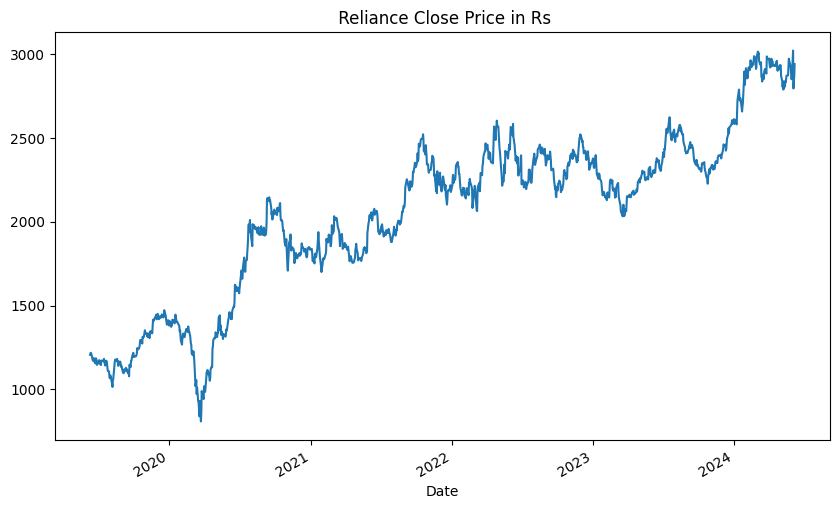

In [3]:
df['Close'].plot(kind='line', figsize=(10, 6), title=' Reliance Close Price in Rs')


SIMPLE CROSSOVER MA BUY AND SELL SIGNALS:

            Buy Signal: SMA 20 > SMA 50

When the short-term SMA moves above the long-term SMA, it suggests that recent price movements are strong enough to overcome longer-term average trends. This can indicate a potential bullish trend reversal or acceleration of an existing uptrend, signaling a buy opportunity.

            Sell Signal: SMA 20 < SMA 50

Conversely, when the short-term SMA moves below the long-term SMA, it indicates that recent price movements are weaker compared to longer-term trends. This can suggest a potential bearish trend reversal or a slowdown in an existing uptrend, signaling a sell opportunity.

In [4]:
# Generating signals:

def SMA_crossover_strategy(df, sma_short, sma_long):

  df['SMA_short'] = df['Close'].rolling(window = sma_short).mean()
  df['SMA_long'] = df['Close'].rolling(window = sma_long).mean()

  df['Return'] = np.log(df['Close'].pct_change()+1)
  df['Signal'] = np.where(df['SMA_short']>df['SMA_long'],1,0)

  df['Position'] = df['Signal'].diff() #1 for buy signal, -1 for sell
  df['Buy_Price'] = np.where(df['Position'].shift(1) == 1, df['Close'], np.nan) # the trade gets executed the next day(if previous day signal is 1, note down close price)
  df['Buy_Price'] = np.where(df['Signal'].shift(1) == 1 ,df['Buy_Price'].ffill(), np.nan)
  df['Sell_Price'] = np.where(df['Position'] == -1, df['Close'], np.nan)

  df['Strategy_Return'] = df['Signal'].shift(1)*df['Return']

  return df


In [7]:
def performance(df):

  trades = df.dropna(subset=['Sell_Price'])
  pnl = (trades['Sell_Price'] - trades['Buy_Price']).sum()
  no_of_trades = trades.shape[0]
  average_trade = pnl/no_of_trades
  winning_trades = (trades['Sell_Price'] - trades['Buy_Price']>0).sum()
  win_rate = winning_trades/no_of_trades
  market_return = np.exp(df['Return'].sum())
  strategy_return = np.exp(df['Strategy_Return'].sum())
  return {
        'PnL': pnl,
        'Average Trade': average_trade,
        'Win Rate': win_rate,
        'Market Return': market_return,
        'Strategy Return': strategy_return
    }

In [8]:
performance(SMA_crossover_strategy(df, 18, 30))

{'PnL': 1561.9992650000002,
 'Average Trade': 82.21048763157896,
 'Win Rate': 0.5263157894736842,
 'Market Return': 2.437441014406356,
 'Strategy Return': 2.931650685394401}

In [9]:
# Exploreing different combinations of SMA window sizes:

def optimise(df, sma_slow_range, sma_fast_range):
  results = []

  for short_window in sma_fast_range:
      for long_window in sma_slow_range:
            if short_window < long_window:  # short window is less than long window
                profit = performance(SMA_crossover_strategy(df.copy(), short_window, long_window))
                results.append({
                    'Short Window': short_window,
                    'Long Window': long_window,
                    'PnL': profit['PnL'],
                    'Average Trade': profit['Average Trade'],
                    'Win Rate': profit['Win Rate'],
                    'Market Return': profit['Market Return'],
                    'Strategy Return': profit['Strategy Return']
                })

  results_df = pd.DataFrame(results)

  return results_df


In [10]:
sma_slow_range = range(1,101)
sma_fast_range = range(1,101)

In [11]:
results_df = optimise(df, sma_slow_range, sma_fast_range)
final = results_df.sort_values(by= 'PnL' and 'Strategy Return', ascending = False).head(4)
final

,Short Window,Long Window,PnL,Average Trade,Win Rate,Market Return,Strategy Return
1558,18,30,1561.999265,82.210488,0.526316,2.437441,2.931651
579,7,8,814.251158,7.080445,0.434783,2.437441,2.910867
1631,19,22,1557.828737,39.944327,0.435897,2.437441,2.898225
28,1,30,1963.598388,42.686921,0.217391,2.437441,2.893070


In [13]:
pip install quantstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.4 MB/s eta 0:00:00


In [14]:
import quantstats as qs
qs.extend_pandas()

In [15]:
# Generating the QuantStats report for each specified strategy window
windows = [(18, 30), (7, 8)]

for sma_short, sma_long in windows:
    strategy_df = SMA_crossover_strategy(df.copy(), sma_short, sma_long)
    strategy_returns = strategy_df['Strategy_Return'].dropna()
    market_returns = strategy_df['Return'].cumsum().apply(np.exp).dropna()

    strategy_returns.index = pd.to_datetime(strategy_returns.index)
    market_returns.index = pd.to_datetime(market_returns.index)


    qs.reports.html(strategy_returns, market_returns, output=f'report_{sma_short}_{sma_long}.html')
